# Explore here

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import utils as eda
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import warnings

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

In [36]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"

total_data = pd.read_csv(url)

In [37]:
eda.analisis(total_data)


Vistazo general:
                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211

Variables numéricas: ['sales']
Variables no numéricas: ['date']

Tamaño del dataset: (366, 2)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None

Valores nulos por columna:
date     0
sales    0
dtype: int64

Filas duplicadas:
Empty DataFrame
Columns: [date, sales]
Index: []

distribucion de datos:
             sales
count   366.000000
mean    524.963968
std     275.089698
min      53.803211
25%     290.186822
50%     520.699468
75%     763.289263
max    1000.482785


In [38]:
# Convertir la columna date a datetime
total_data["date"] = pd.to_datetime(total_data["date"])

# Establecer la fecha como índice
total_data = total_data.set_index("date")

# Crear la serie temporal
ts = total_data["sales"]

print("Serie temporal creada:")
print(ts.head())
print(f"\nTipo de índice: {type(ts.index)}")
print(f"Rango de fechas: {ts.index.min()} a {ts.index.max()}")
print(f"Número de observaciones: {len(ts)}")
print(f"Frecuencia detectada: {ts.index.inferred_freq}")

Serie temporal creada:
date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

Tipo de índice: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Rango de fechas: 2022-09-03 17:10:08.079328 a 2023-09-03 17:10:08.079328
Número de observaciones: 366
Frecuencia detectada: D


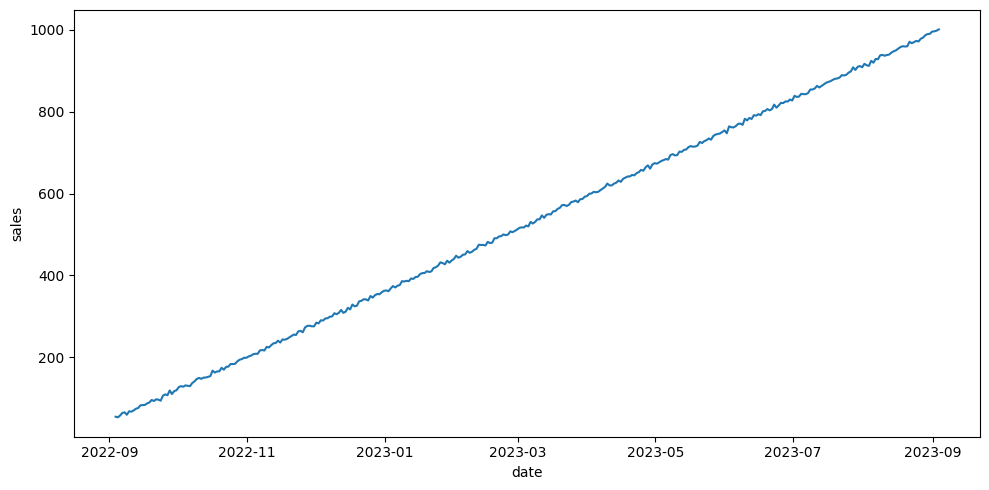

In [39]:
#Visualizacion de serie temporal 
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()


In [40]:
#Análisis de la tendencia

decomposition = seasonal_decompose(ts, period = 12)
decomposition

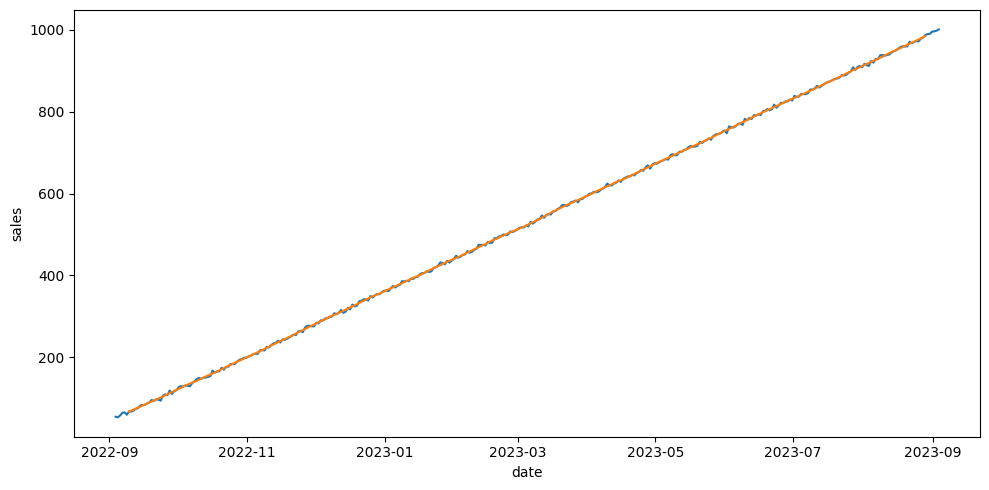

In [41]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Analisis de resultados:
1. Oscilaciones alrededor de la tendencia: La serie original oscila alrededor de la tendencia, lo que confirma la presencia de estacionalidad.
2. La serie deventas muestra un crecimiento sostenido a lo largo del año, con estacionalidad semanal y sin anomalías graves.

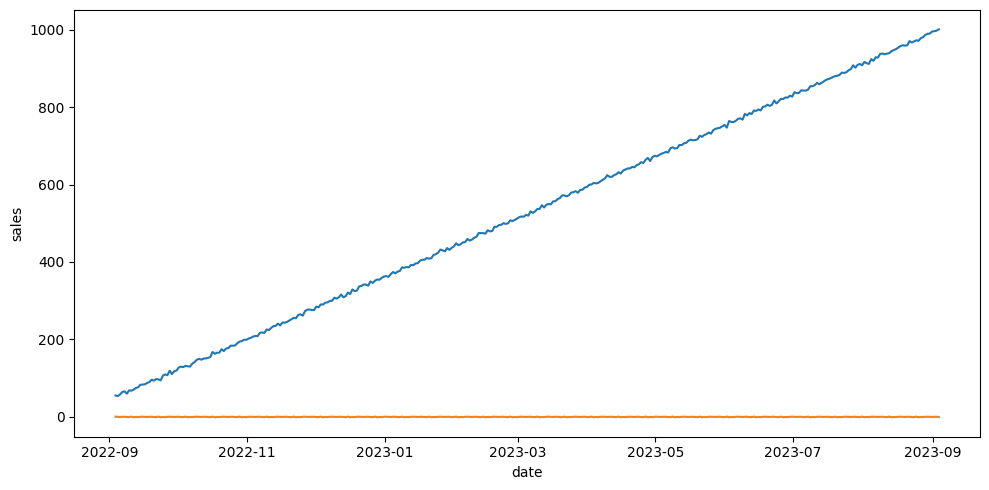

In [42]:
#Análisis de la estacionalidad
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Analisis de resultados: 
La serie de ventas tiene una estacionalidad semanal clara, estable y relevante. Esto valida el uso de modelos estacionales como ARIMA 

In [43]:
#Prueba Dickey-Fuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Analisis de resultados: 
1. p-value muy alto (0.986):hay un 98.6% de probabilidad de que la serie no sea estacionaria. No pdemos rechazar la hipótesis nula.
2. Test Statistic positivo: Un valor positivo (0.545) está muy lejos de los valores críticos negativos, confirmando la no estacionaridad.

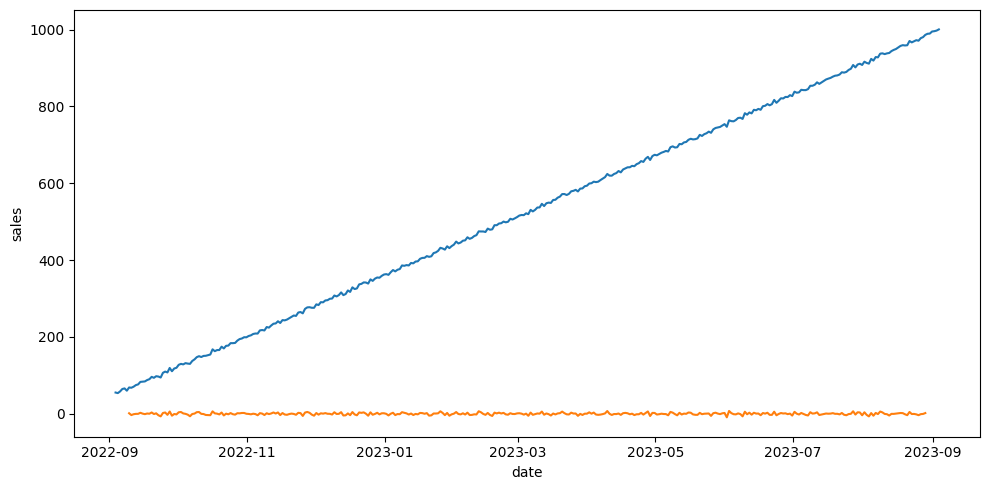

In [44]:
#Análisis de la variabilidad
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()


Analisis de resultados: 
1. Variabilidad constante:
La amplitud de los residuos parece relativamente constante a lo largo del tiempo, lo que sugiere que la varianza del ruido no cambia significativamente.
2. Ausencia de valores atípicos extremos:
No se observan picos o caídas bruscas en los residuos, lo que indica que no hay outliers importantes.
3. La variabilidad de la serie, una vez eliminados la tendencia y la estacionalidad, es principalmente aleatoria y constante.

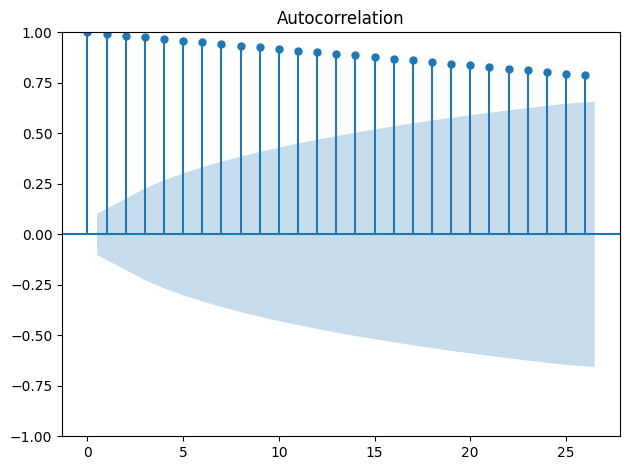

In [45]:
#Análisis de la autocorrelación
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()


Analisis de resultados:
1. Desaceleración lenta de la correlación:
Si la autocorrelación disminuye lentamente es una señal de que la serie tiene tendencia.
2. La serie de ventas diarias tiene memoria: lo que pasa hoy depende de lo que pasó en días anteriores.
3. La presencia de tendencia y estacionalidad se confirma con este gráfico.
4. Hay un patrón semanal muy claro (estacionalidad de 7 días)


In [46]:
# Entrenamiento del modelo ARIMA
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [47]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=1843.155, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2209.657, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=1840.533, Time=2.95 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=1840.763, Time=2.49 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=1842.448, Time=3.21 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=1842.555, Time=2.65 sec
 ARIMA(2,0,3)(2,0,1)[7] intercept   : AIC=1838.849, Time=2.74 s

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood                -912.752
Date:                            Wed, 20 Aug 2025   AIC                           1835.504
Time:                                    21:16:55   BIC                           1855.004
Sample:                                09-04-2022   HQIC                          1843.254
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3859      0.202     11.819      0.000       1.990       2.782
ar.L1         -0.0645      0.052     -1.251      0.211      -0.166       0.037
ma.L1         -0.9638      0.017    -56.361      0.000      -0.997      -0.930
ar.S.L7        0.1376      0.053      2.575      0.010       0.033       0.242
sigma2         8.6283      0.670     12.877      0.000       7.315       9.942
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.98   Prob(JB):                         0.78
Heteroskedasticity (H):               0.86   Skew:                             0.06
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
forecast = model.predict(10)
forecast

2023-09-04 17:10:08.079328    1.958974
2023-09-05 17:10:08.079328    2.702206
2023-09-06 17:10:08.079328    2.308054
2023-09-07 17:10:08.079328    2.982694
2023-09-08 17:10:08.079328    2.355025
2023-09-09 17:10:08.079328    2.452551
2023-09-10 17:10:08.079328    2.672236
2023-09-11 17:10:08.079328    2.510771
2023-09-12 17:10:08.079328    2.613026
2023-09-13 17:10:08.079328    2.558797
Freq: D, dtype: float64

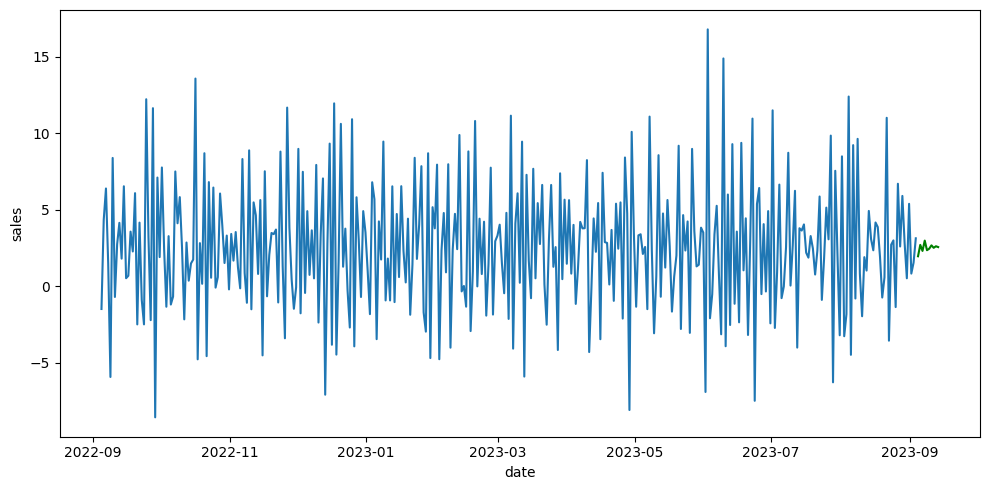

In [ ]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [ ]:
# Último valor real de ventas
last_value = ts.iloc[-1] 
forecast_original = last_value + forecast.cumsum()
print(forecast_original)

2023-09-04 17:10:08.079328    1002.441759
2023-09-05 17:10:08.079328    1005.143965
2023-09-06 17:10:08.079328    1007.452020
2023-09-07 17:10:08.079328    1010.434713
2023-09-08 17:10:08.079328    1012.789739
2023-09-09 17:10:08.079328    1015.242289
2023-09-10 17:10:08.079328    1017.914525
2023-09-11 17:10:08.079328    1020.425295
2023-09-12 17:10:08.079328    1023.038321
2023-09-13 17:10:08.079328    1025.597118
Freq: D, dtype: float64


Analisis de resultados: El modelo espera que las ventas sigan subiendo cada día, con incrementos diarios entre 2 y 3 euros.